![alt text][logo]

[logo]: https://github.com/legolason/PyQSOFit/blob/master/pyqsofit/QSOFit_logo.png?raw=true


# PyQSOFit


PyQSOFit is a flexible tool to decompose quasar spectra. It was originally translated from [Yue Shen](http://quasar.astro.illinois.edu/)'s IDL qsofit code, but not exactly the same. With this program, people can get the information of quasar continuum and emission lines, e.g., continuum slope, line FWHM, line dispersion, EW, peak, etc. The main flows of this code are:

1) We decompose the host galaxy and quasar component with the PCA method if needed
2) We fit the continuum with several components (Power-Law, Polynomial, Fe II, Balmer Continuum) using some line free windows
3) We fit line complexes one by one, including H$\alpha$, H$\beta$, Mg II, C III], CIV and Ly$\alpha$ complex. In each complex, broad and narrow Gaussian profiles are used to fit different emission lines. 

For the details, you can read [Shen et al. (2015)](http://adsabs.harvard.edu/abs/2018arXiv181001447S), [Guo et al. (2018)](http://adsabs.harvard.edu/abs/2018arXiv180904610G) and Wang et al.(2018, in prepration)


## Installation and Requirements

To install this code, just download and install it with ``pip``:

``git clone https://github.com/legolason/PyQSOFit``<br>
``cd PyQSOFit``<br>
``python -m pip install .``<br>


This code was tested Python 3.9. These packages are __required__, but should have been installed automatically during the step above:

1) [Numpy](http://www.numpy.org/)<br>
2) [Scipy](https://www.scipy.org/)<br>
3) [Astropy](http://www.astropy.org/)<br>
4) [PyAstronomy](https://pyastronomy.readthedocs.io/en/latest/pyaCDoc/installingPyA.html)<br>
5) [LMFIT](https://lmfit.github.io/lmfit-py/)<br>
6) [Sfdmap](https://github.com/kbarbary/sfdmap): dust reddening map from [Schlegel et al. (2008)](http://www.adsabs.harvard.edu/abs/1998ApJ...500..525S), which can be downloaded [here](https://github.com/kbarbary/sfddata)<br>

These packages are __optional__. They are not installed automatically but must be installed for parameter uncertainty estimates:

1)  [emcee](https://emcee.readthedocs.io/en/stable/)<br>
2) [pandas](https://pandas.pydata.org/)<br>
3) [corner](https://corner.readthedocs.io/en/latest/)<br>

Eigenspectra of galaxy and quasar from Yip et al. [(2004a)](http://adsabs.harvard.edu/abs/2004AJ....128..585Y), [(2004b)](http://adsabs.harvard.edu/abs/2004AJ....128.2603Y)
and Optical/UV Fe II templates are included in this package. We suggest that install python through [anaconda](https://www.anaconda.com/), which incorporates most packages you need.  

## Key features
1) Fit the whole spectra input or fit each line locally using ``wave_range`` parameter
2) Parameter uncertaianties can be computed for each parameter. The uncertainties from least-squares fitting is usually not robust, so we do not output those as default results (but the user still can read out this errors through ``lmfit.params``). The best way to calculate the error is using MCMC. In previous versions of the code, we used a Monte Carlo resampling method, which perturbs the flux based on the input error. Computing parameter uncertainties will take longer, but in practice we found that MCMC is not significantly slower than the resampling method and MCMC probably gives more reliable parameter uncertainties and covariances. 
3) A 3rd order polynomial component accounts for dust reddening if any.
4) Iterative sigma clipping can be used to clean the spectrum for absorbed continuum fitting. 
5) One can block serval ranges on the spectrum for bad S/N ratio pixels or absorption lines.
6) The code directly saves out the properties of emission lines, e.g., FWHM, line dispersion, EW, Peak, line flux for the broad components and continuum luminosity at 1350, 3000, 5100A.
7) One can remove the bad pixels caused by the cosmic ray or the sky. 



## Possible future updates
1) Option for using Gauss-Hermite profile to fit the emission lines.<br>
2) Simultaneously fit several epochs for the same source since the time domain era is coming.<br>
3) Add functions to fit the absorption lines.<br>
4) Produce more secondary parameters from spectral fitting.<br>
5) Speed up the code by e.g., choosing better initial conditions (especially for the continuum and narrow-line flux normalizations).<br>
6) Option for automatically determining the number of broad emission line components to include in a fit using e.g., BIC. This will take longer to execute initially but might make the MCMC sampling faster and fits more reliable if fewer components are used, especially for low S/N or BAL quasar spectra.<br>
7) Better integration with pPXF, specutils, etc.<br>
8) Better code documentation.<br>


## Authors
[Hengxiao Guo](https://hengxiaoguo.wixsite.com/hengxiaoguo), hengxiaoguo AT gmail.com (UIUC)<br>
[Yue Shen](http://quasar.astro.illinois.edu/), shenyue AT illinois.edu (UIUC)<br>
Shu Wang, wangshukiaa AT pku.edu.cn (Peking University)<br>
[Colin J. Burke](https://burke86.github.io/), colinjb2 AT illinois.edu (UIUC)<br>


## Acknowledgement
If our code makes your life easier, it would be appreciated to cite us:<br>
1) [Guo, H., Liu, X., Shen, Y., et al. 2018, arXiv:1809.04610](http://adsabs.harvard.edu/abs/2018arXiv180904610G)<br>
2) [Shen, Y., Hall, P.~B., Horne, K., et al.\ 2018, arXiv:1810.01447](http://adsabs.harvard.edu/abs/2018arXiv181001447S)


In [1]:
%matplotlib inline
import glob, os,sys,timeit
import matplotlib
import numpy as np
#sys.path.append('../')
from pyqsofit.PyQSOFit import QSOFit
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Use custom matplotlib style to make Yue happy
QSOFit.set_mpl_style()

In [2]:
# Show the versions so we know what works
import astropy
import lmfit
import pyqsofit
print(astropy.__version__)
print(lmfit.__version__)
print(pyqsofit.__version__)

import emcee # optional, for MCMC
print(emcee.__version__)

5.1
1.0.3
1.2.0
3.1.2


## Detailed Usage

## 1. Fit type 1 QSO

__Step 1: Set up the model input parameters__<br>
Firstly, run the script below to produce the line list file, qsopar.fits, containing lines and their constraints, which will be needed in the following fitting program. From this file, you can change some specific parameters to suit your requirements, e.g., fitting range, line width, tie line center, tie line sigma, etc. If you want to fit extra lines, please append it to corresponding complex. Note that our line wavelength and sigma in the list are in Ln scale, like Lnlambda, Lnsigma. 

In [3]:
path_ex = '/home/colinjb2/PyQSOFit/example' # The absolute path to the example directory 

In [4]:
"""
Create parameter file
lambda    complexname  minwav maxwav linename ngauss inisca minsca maxsca inisig minsig maxsig voff vindex windex findex fvalue
"""

newdata = np.rec.array([
(6564.61, r'H$\alpha$', 6400, 6800, 'Ha_br',   3, 0.1, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.015, 0, 0, 0, 0.05 ),
(6564.61, r'H$\alpha$', 6400, 6800, 'Ha_na',   1, 0.1, 0.0, 1e10, 1e-3, 5e-4,   0.0017, 0.01,  1, 1, 0, 0.002),
(6549.85, r'H$\alpha$', 6400, 6800, 'NII6549', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 5e-3,  1, 1, 1, 0.001),
(6585.28, r'H$\alpha$', 6400, 6800, 'NII6585', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 5e-3,  1, 1, 1, 0.003),
(6718.29, r'H$\alpha$', 6400, 6800, 'SII6718', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 5e-3,  1, 1, 2, 0.001),
(6732.67, r'H$\alpha$', 6400, 6800, 'SII6732', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 5e-3,  1, 1, 2, 0.001),

(4862.68, r'H$\beta$', 4640, 5100, 'Hb_br',     1, 0.1, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.01, 0, 0, 0, 0.01 ),
(4862.68, r'H$\beta$', 4640, 5100, 'Hb_na',     1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 0.01, 1, 1, 0, 0.002),
(4960.30, r'H$\beta$', 4640, 5100, 'OIII4959c', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 0.01, 1, 1, 0, 0.002),
(5008.24, r'H$\beta$', 4640, 5100, 'OIII5007c', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 0.01, 1, 1, 0, 0.004),
#(4960.30, 'Hb', 4640, 5100, 'OIII4959w',   1, 0.1, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.001),
#(5008.24, 'Hb', 4640, 5100, 'OIII5007w',   1, 0.1, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.002),
#(4687.02, 'Hb', 4640, 5100, 'HeII4687_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.005, 0, 0, 0, 0.001),
#(4687.02, 'Hb', 4640, 5100, 'HeII4687_na', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 0.005, 1, 1, 0, 0.001),

#(3934.78, 'CaII', 3900, 3960, 'CaII3934' , 2, 0.1, 0.0, 1e10, 1e-3, 3.333e-4, 0.0017, 0.01, 99, 0, 0, -0.001),

#(3728.48, 'OII', 3650, 3800, 'OII3728', 1, 0.1, 0.0, 1e10, 1e-3, 3.333e-4, 0.0017, 0.01, 1, 1, 0, 0.001),
    
#(3426.84, 'NeV', 3380, 3480, 'NeV3426',    1, 0.1, 0.0, 1e10, 1e-3, 3.333e-4, 0.0017, 0.01, 0, 0, 0, 0.001),
#(3426.84, 'NeV', 3380, 3480, 'NeV3426_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.0025,   0.02,   0.01, 0, 0, 0, 0.001),

(2798.75, 'MgII', 2700, 2900, 'MgII_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.0017, 0, 0, 0, 0.05),
(2798.75, 'MgII', 2700, 2900, 'MgII_na', 2, 0.1, 0.0, 1e10, 1e-3, 5e-4, 0.0017, 0.01, 1, 1, 0, 0.002),

(1908.73, 'CIII', 1700, 1970, 'CIII_br',   2, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 99, 0, 0, 0.01),
#(1908.73, 'CIII', 1700, 1970, 'CIII_na',   1, 0.1, 0.0, 1e10, 1e-3, 5e-4,  0.0017, 0.01,  1, 1, 0, 0.002),
#(1892.03, 'CIII', 1700, 1970, 'SiIII1892', 1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005),
#(1857.40, 'CIII', 1700, 1970, 'AlIII1857', 1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005),
#(1816.98, 'CIII', 1700, 1970, 'SiII1816',  1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002),
#(1786.7,  'CIII', 1700, 1970, 'FeII1787',  1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002),
#(1750.26, 'CIII', 1700, 1970, 'NIII1750',  1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001),
#(1718.55, 'CIII', 1700, 1900, 'NIV1718',   1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001),

(1549.06, 'CIV', 1500, 1700, 'CIV_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05,   0.015, 0, 0, 0, 0.05 ),
(1549.06, 'CIV', 1500, 1700, 'CIV_na', 1, 0.1, 0.0, 1e10, 1e-3, 5e-4,  0.0017, 0.01,  1, 1, 0, 0.002),
#(1640.42, 'CIV', 1500, 1700, 'HeII1640',    1, 0.1, 0.0, 1e10, 1e-3, 5e-4,   0.0017, 0.008, 1, 1, 0, 0.002),
#(1663.48, 'CIV', 1500, 1700, 'OIII1663',    1, 0.1, 0.0, 1e10, 1e-3, 5e-4,   0.0017, 0.008, 1, 1, 0, 0.002),
#(1640.42, 'CIV', 1500, 1700, 'HeII1640_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002),
#(1663.48, 'CIV', 1500, 1700, 'OIII1663_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002),

#(1402.06, 'SiIV', 1290, 1450, 'SiIV_OIV1', 1, 0.1, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05),
#(1396.76, 'SiIV', 1290, 1450, 'SiIV_OIV2', 1, 0.1, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05),
#(1335.30, 'SiIV', 1290, 1450, 'CII1335',   1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001),
#(1304.35, 'SiIV', 1290, 1450, 'OI1304',    1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001),

(1215.67, 'Lya', 1150, 1290, 'Lya_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05,   0.02, 0, 0, 0, 0.05 ),
(1215.67, 'Lya', 1150, 1290, 'Lya_na', 1, 0.1, 0.0, 1e10, 1e-3, 5e-4,  0.0017, 0.01, 0, 0, 0, 0.002)],

formats = 'float32,      a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32',
names  =  ' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,  voff,     vindex, windex,  findex,  fvalue')

# Header
hdr = fits.Header()
hdr['lambda'] = 'Vacuum Wavelength in Ang'
hdr['minwav'] = 'Lower complex fitting wavelength range'
hdr['maxwav'] = 'Upper complex fitting wavelength range'
hdr['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr['inisca'] = 'Initial guess of line scale [in ??]'
hdr['minsca'] = 'Lower range of line scale [??]'
hdr['maxsca'] = 'Upper range of line scale [??]'

hdr['inisig'] = 'Initial guess of linesigma [in lnlambda]'
hdr['minsig'] = 'Lower range of line sigma [lnlambda]'  
hdr['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr['fvalue'] = 'Relative scale factor for entries w/ same findex'

# Save line info
hdu = fits.BinTableHDU(data=newdata, header=hdr, name='data')
hdu.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)

__Print the table:__

In [5]:
from astropy.table import Table
Table(newdata)

<Table length=17>
 lambda  compname  minwav  maxwav  linename ngauss  inisca  minsca     maxsca     inisig  minsig  maxsig   voff  vindex windex findex  fvalue
float32  bytes20  float32 float32  bytes20  int32  float32 float32    float32    float32 float32 float32 float32 int32  int32  int32  float32
------- --------- ------- ------- --------- ------ ------- ------- ------------- ------- ------- ------- ------- ------ ------ ------ -------
6564.61 H$\alpha$  6400.0  6800.0     Ha_br      3     0.1     0.0 10000000000.0   0.005   0.004    0.05   0.015      0      0      0    0.05
6564.61 H$\alpha$  6400.0  6800.0     Ha_na      1     0.1     0.0 10000000000.0   0.001  0.0005  0.0017    0.01      1      1      0   0.002
6549.85 H$\alpha$  6400.0  6800.0   NII6549      1     0.1     0.0 10000000000.0   0.001 0.00023  0.0017   0.005      1      1      1   0.001
6585.28 H$\alpha$  6400.0  6800.0   NII6585      1     0.1     0.0 10000000000.0   0.001 0.00023  0.0017   0.005      1      1      1   0.003
6718.29 H$\alpha$  6400.0  6800.0   SII6718      1     0.1     0.0 10000000000.0   0.001 0.00023  0.0017   0.005      1      1      2   0.001
6732.67 H$\alpha$  6400.0  6800.0   SII6732      1     0.1     0.0 10000000000.0   0.001 0.00023  0.0017   0.005      1      1      2   0.001
4862.68  H$\beta$  4640.0  5100.0     Hb_br      1     0.1     0.0 10000000000.0   0.005   0.004    0.05    0.01      0      0      0    0.01
4862.68  H$\beta$  4640.0  5100.0     Hb_na      1     0.1     0.0 10000000000.0   0.001 0.00023  0.0017    0.01      1      1      0   0.002
 4960.3  H$\beta$  4640.0  5100.0 OIII4959c      1     0.1     0.0 10000000000.0   0.001 0.00023  0.0017    0.01      1      1      0   0.002
5008.24  H$\beta$  4640.0  5100.0 OIII5007c      1     0.1     0.0 10000000000.0   0.001 0.00023  0.0017    0.01      1      1      0   0.004
2798.75      MgII  2700.0  2900.0   MgII_br      1     0.1     0.0 10000000000.0   0.005   0.004    0.05  0.0017      0      0      0    0.05
2798.75      MgII  2700.0  2900.0   MgII_na      2     0.1     0.0 10000000000.0   0.001  0.0005  0.0017    0.01      1      1      0   0.002
1908.73      CIII  1700.0  1970.0   CIII_br      2     0.1     0.0 10000000000.0   0.005   0.004    0.05   0.015     99      0      0    0.01
1549.06       CIV  1500.0  1700.0    CIV_br      1     0.1     0.0 10000000000.0   0.005   0.004    0.05   0.015      0      0      0    0.05
1549.06       CIV  1500.0  1700.0    CIV_na      1     0.1     0.0 10000000000.0   0.001  0.0005  0.0017    0.01      1      1      0   0.002
1215.67       Lya  1150.0  1290.0    Lya_br      1     0.1     0.0 10000000000.0   0.005   0.004    0.05    0.02      0      0      0    0.05
1215.67       Lya  1150.0  1290.0    Lya_na      1     0.1     0.0 10000000000.0   0.001  0.0005  0.0017    0.01      0      0      0   0.002

Because each line complex is fit independently, there is not an easy way to tie line properties in different line complexes.

__Step 2: Read the spectrum__ <br>
Setup the paths and read in your spectrum. Our code is written under the frame of SDSS spectral data format. Other data is also available as long as they include wavelength, flux, error, and redshift, and make sure the wavelength resolution is the same as SDSS spectrum (For SDSS the pixel scale is 1.e-4 in log space).

In [6]:
path_out = '/home/colinjb2/PyQSOFit/example/data/' # path of fitting results

# Requried
data = fits.open(os.path.join(path_ex, 'data/spec-0332-52367-0639.fits'))
lam = 10**data[1].data['loglam']        # OBS wavelength [A]
flux = data[1].data['flux']             # OBS flux [erg/s/cm^2/A]
err = 1/np.sqrt(data[1].data['ivar'])   # 1 sigma error
z = data[2].data['z'][0]                # Redshift

# Optional
ra = data[0].header['plug_ra']        # RA
dec = data[0].header['plug_dec']      # DEC
plateid = data[0].header['plateid']   # SDSS plate ID
mjd = data[0].header['mjd']           # SDSS MJD
fiberid = data[0].header['fiberid']   # SDSS fiber ID

__Step 3: Fit the spectrum__<br>
Use QSOFit to input the lam, flux, err, z, and other optinal parameters. Use function Fit to perform the fitting. Default settings cannot meet all needs. Please change settings for your own requirements. It depends on what science you need. The following example set dereddening, host decomposition to True.

The ``broad_fwhm`` parameter can be adjusted depending on your definition (default is 1200 km s$^{-1}$).

Reading parameter file: /home/colinjb2/PyQSOFit/example/qsopar.fits
Fitting finished in 0.9s


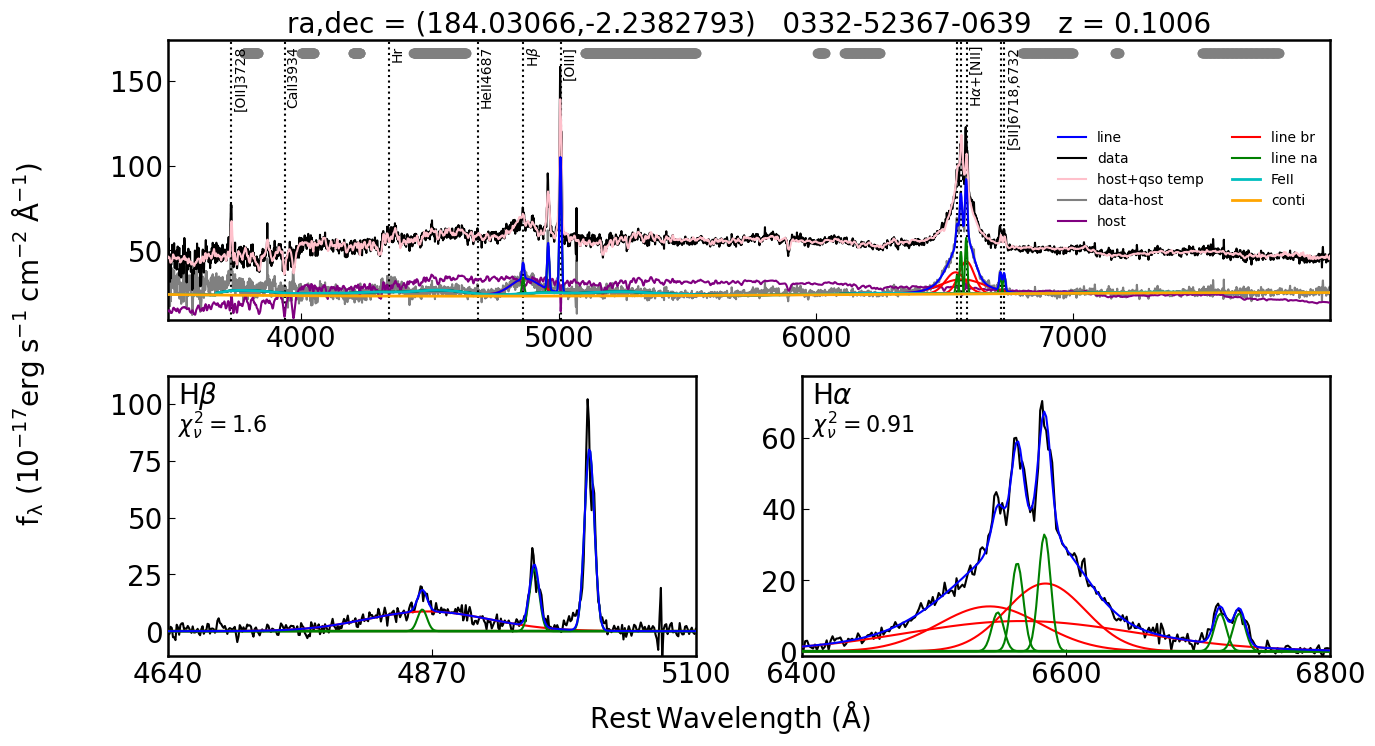

In [7]:
# Prepare data
q = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_ex)

start = timeit.default_timer()
# Do the fitting
q.Fit(name=None, nsmooth=1, and_or_mask=False, deredden=True, reject_badpix=False, wave_range=None, \
      wave_mask=None, decomposition_host=True, Mi=None, npca_gal=5, npca_qso=20, Fe_uv_op=True, \
      Fe_flux_range=np.array([4435,4685]), poly=True, BC=False, rej_abs=False, initial_guess=None, \
      method='leastsq', MCMC=False, nburn=50, nsamp=200, nthin=10, linefit=True,  epsilon_jitter=1e-5, \
      save_result=True, plot_fig=True, save_fig=False, plot_corner=True, plot_line_name=True, \
      plot_legend=True, save_fig_path='.', save_fits_path=path_out, save_fits_name=None, verbose=False)

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

The gray shaded bars at the top are the continuum windows used in the fitting.<br>
__Now you are already done with the QSO fitting part!__

__Step 3(optional): Compute parameter unertaintines__:<br>
For comparison, let's fit the same quasar spectrum, but this time using MCMC to get uncertainties on the parameters. Obviously, this will take significantly longer depending on the number of samples you want to run. You will need the ``pandas`` and ``emcee`` packages to do this. To visualize the posterior parameter distributions and their covariances, you will need the ``corner`` package. It's also usually a good idea to perturb the parameter starting points by a small random number using the ``epsilon_jitter`` argument, and exclude unnecessary line components, otherwise you may get an ''Initial state has a large condition number'' error.

You must install the tqdm library to use progress indicators with emcee


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [18.9196376  19.76552675 18.59351755 18.18962584 19.40367347 19.50915206
 19.31605236 19.12866417]


You must install the tqdm library to use progress indicators with emcee


Reading parameter file: /home/colinjb2/PyQSOFit/example/qsopar.fits
The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [16.71255389 18.08419056 16.91565962 15.20180066 16.65023921 16.26943779
 15.70234598 15.91307286]


You must install the tqdm library to use progress indicators with emcee


The chain is shorter than 50 times the integrated autocorrelation time for 14 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [20.38021565 20.23014774 19.11135607 19.73426965 20.55620493 18.53840862
 20.2677761  20.87743584 19.91586489 17.24654112 18.12914672 18.96771504
 17.72435779 18.07619893]
Fitting finished in 61.6s


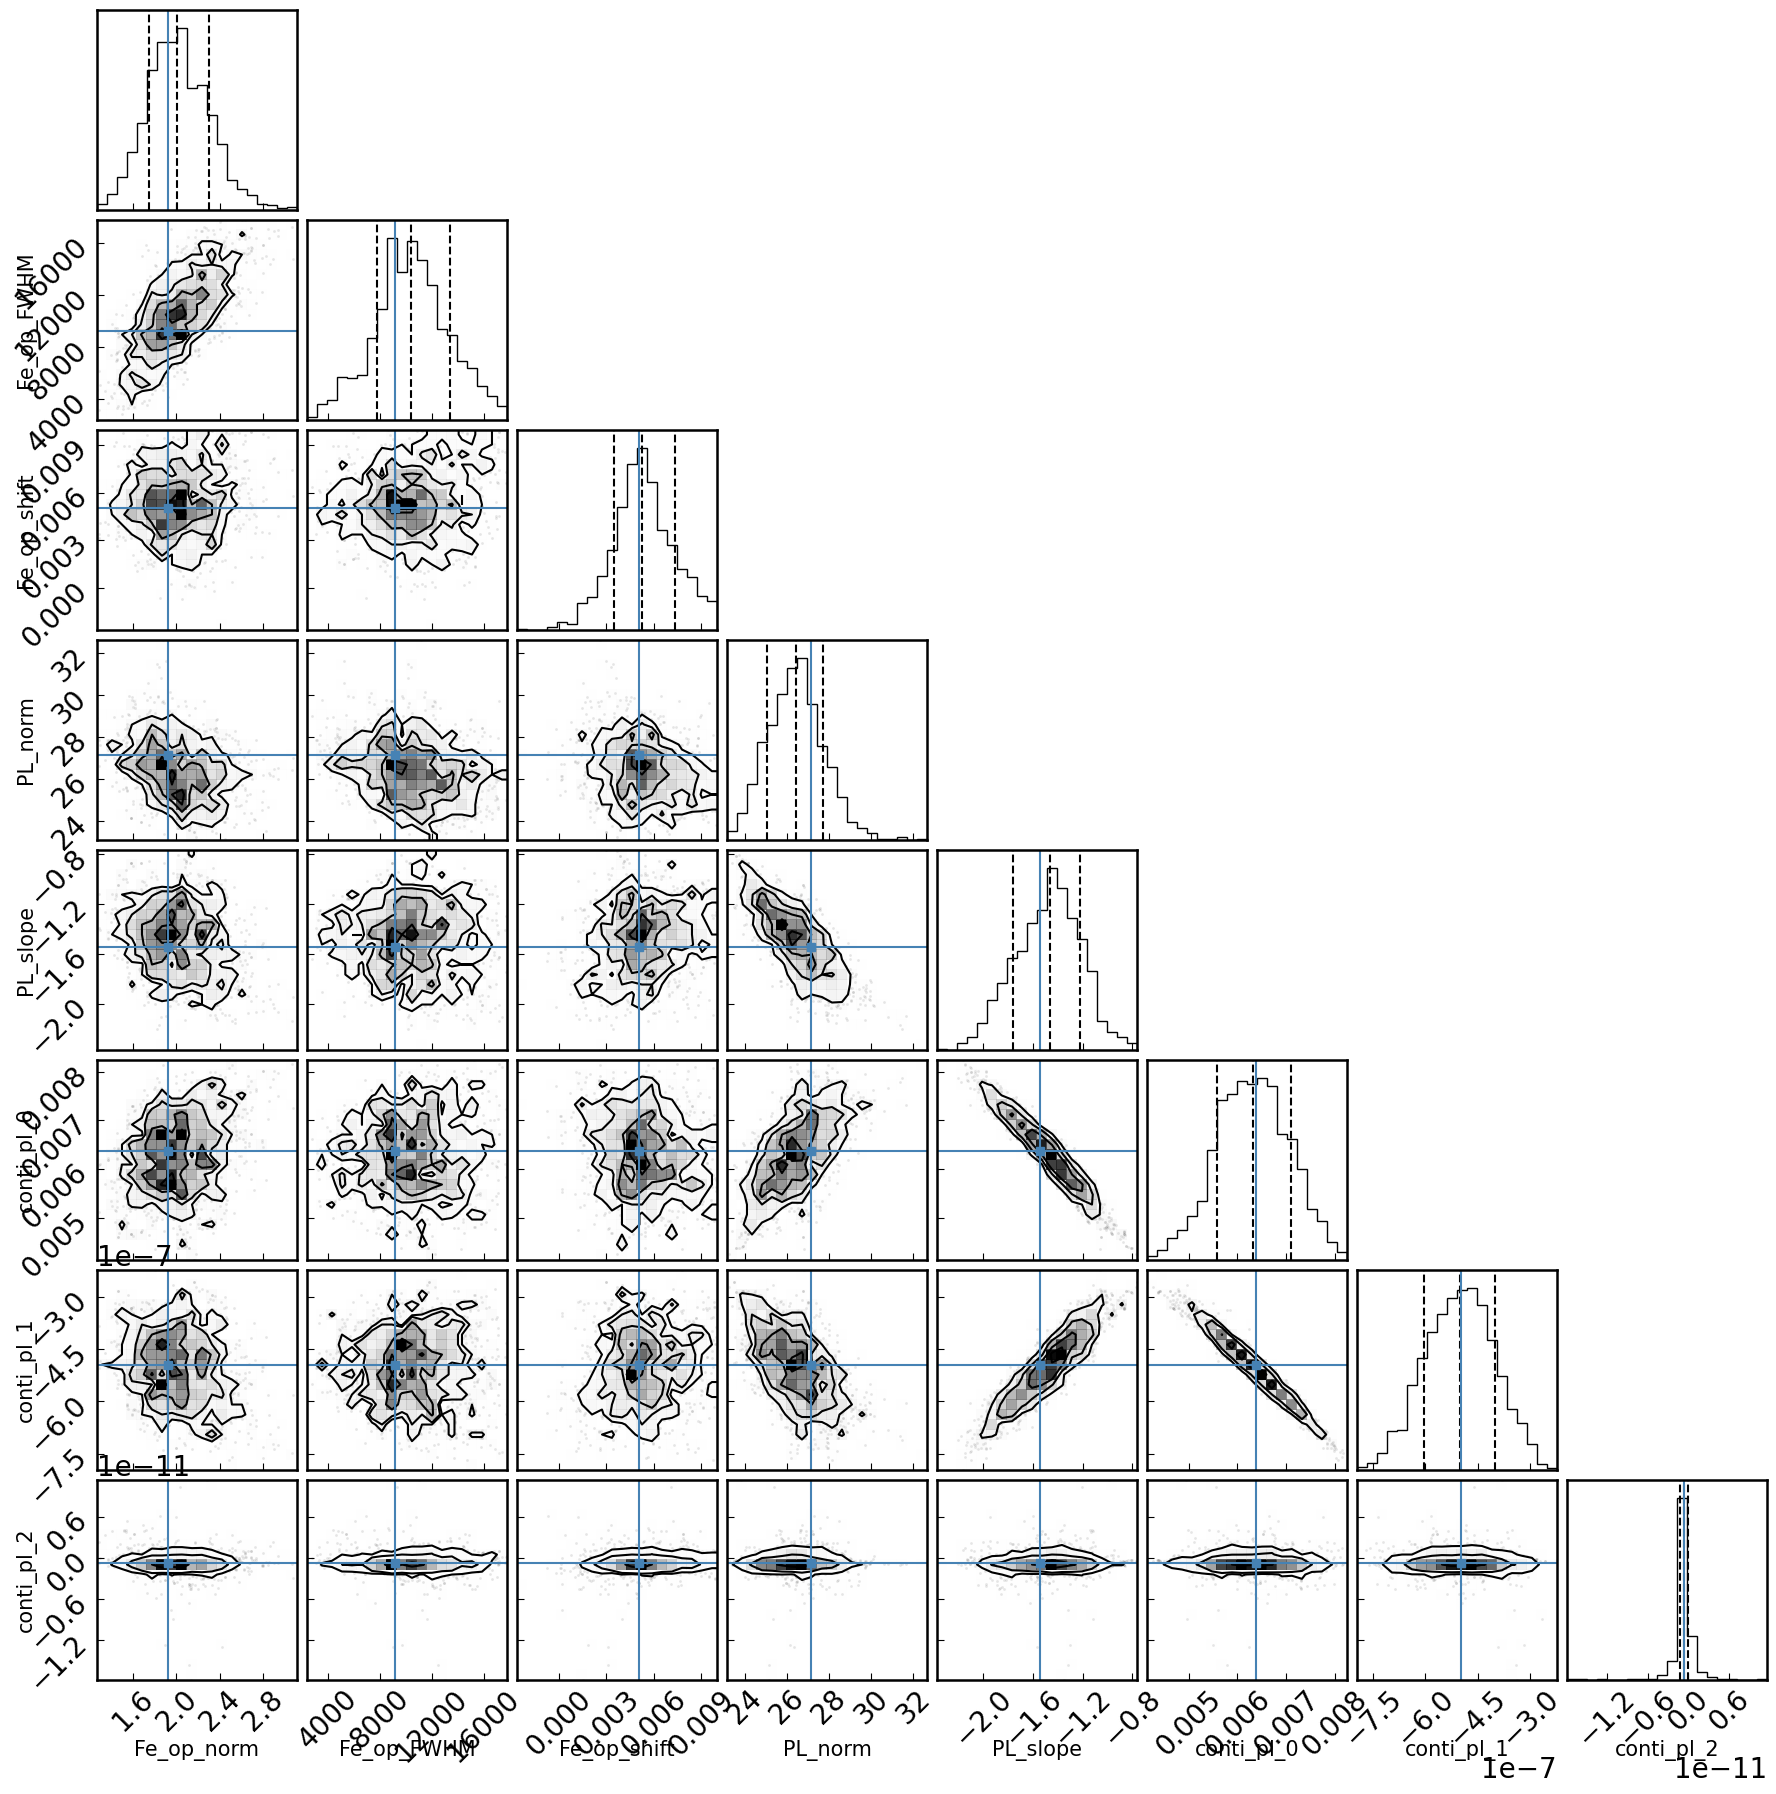

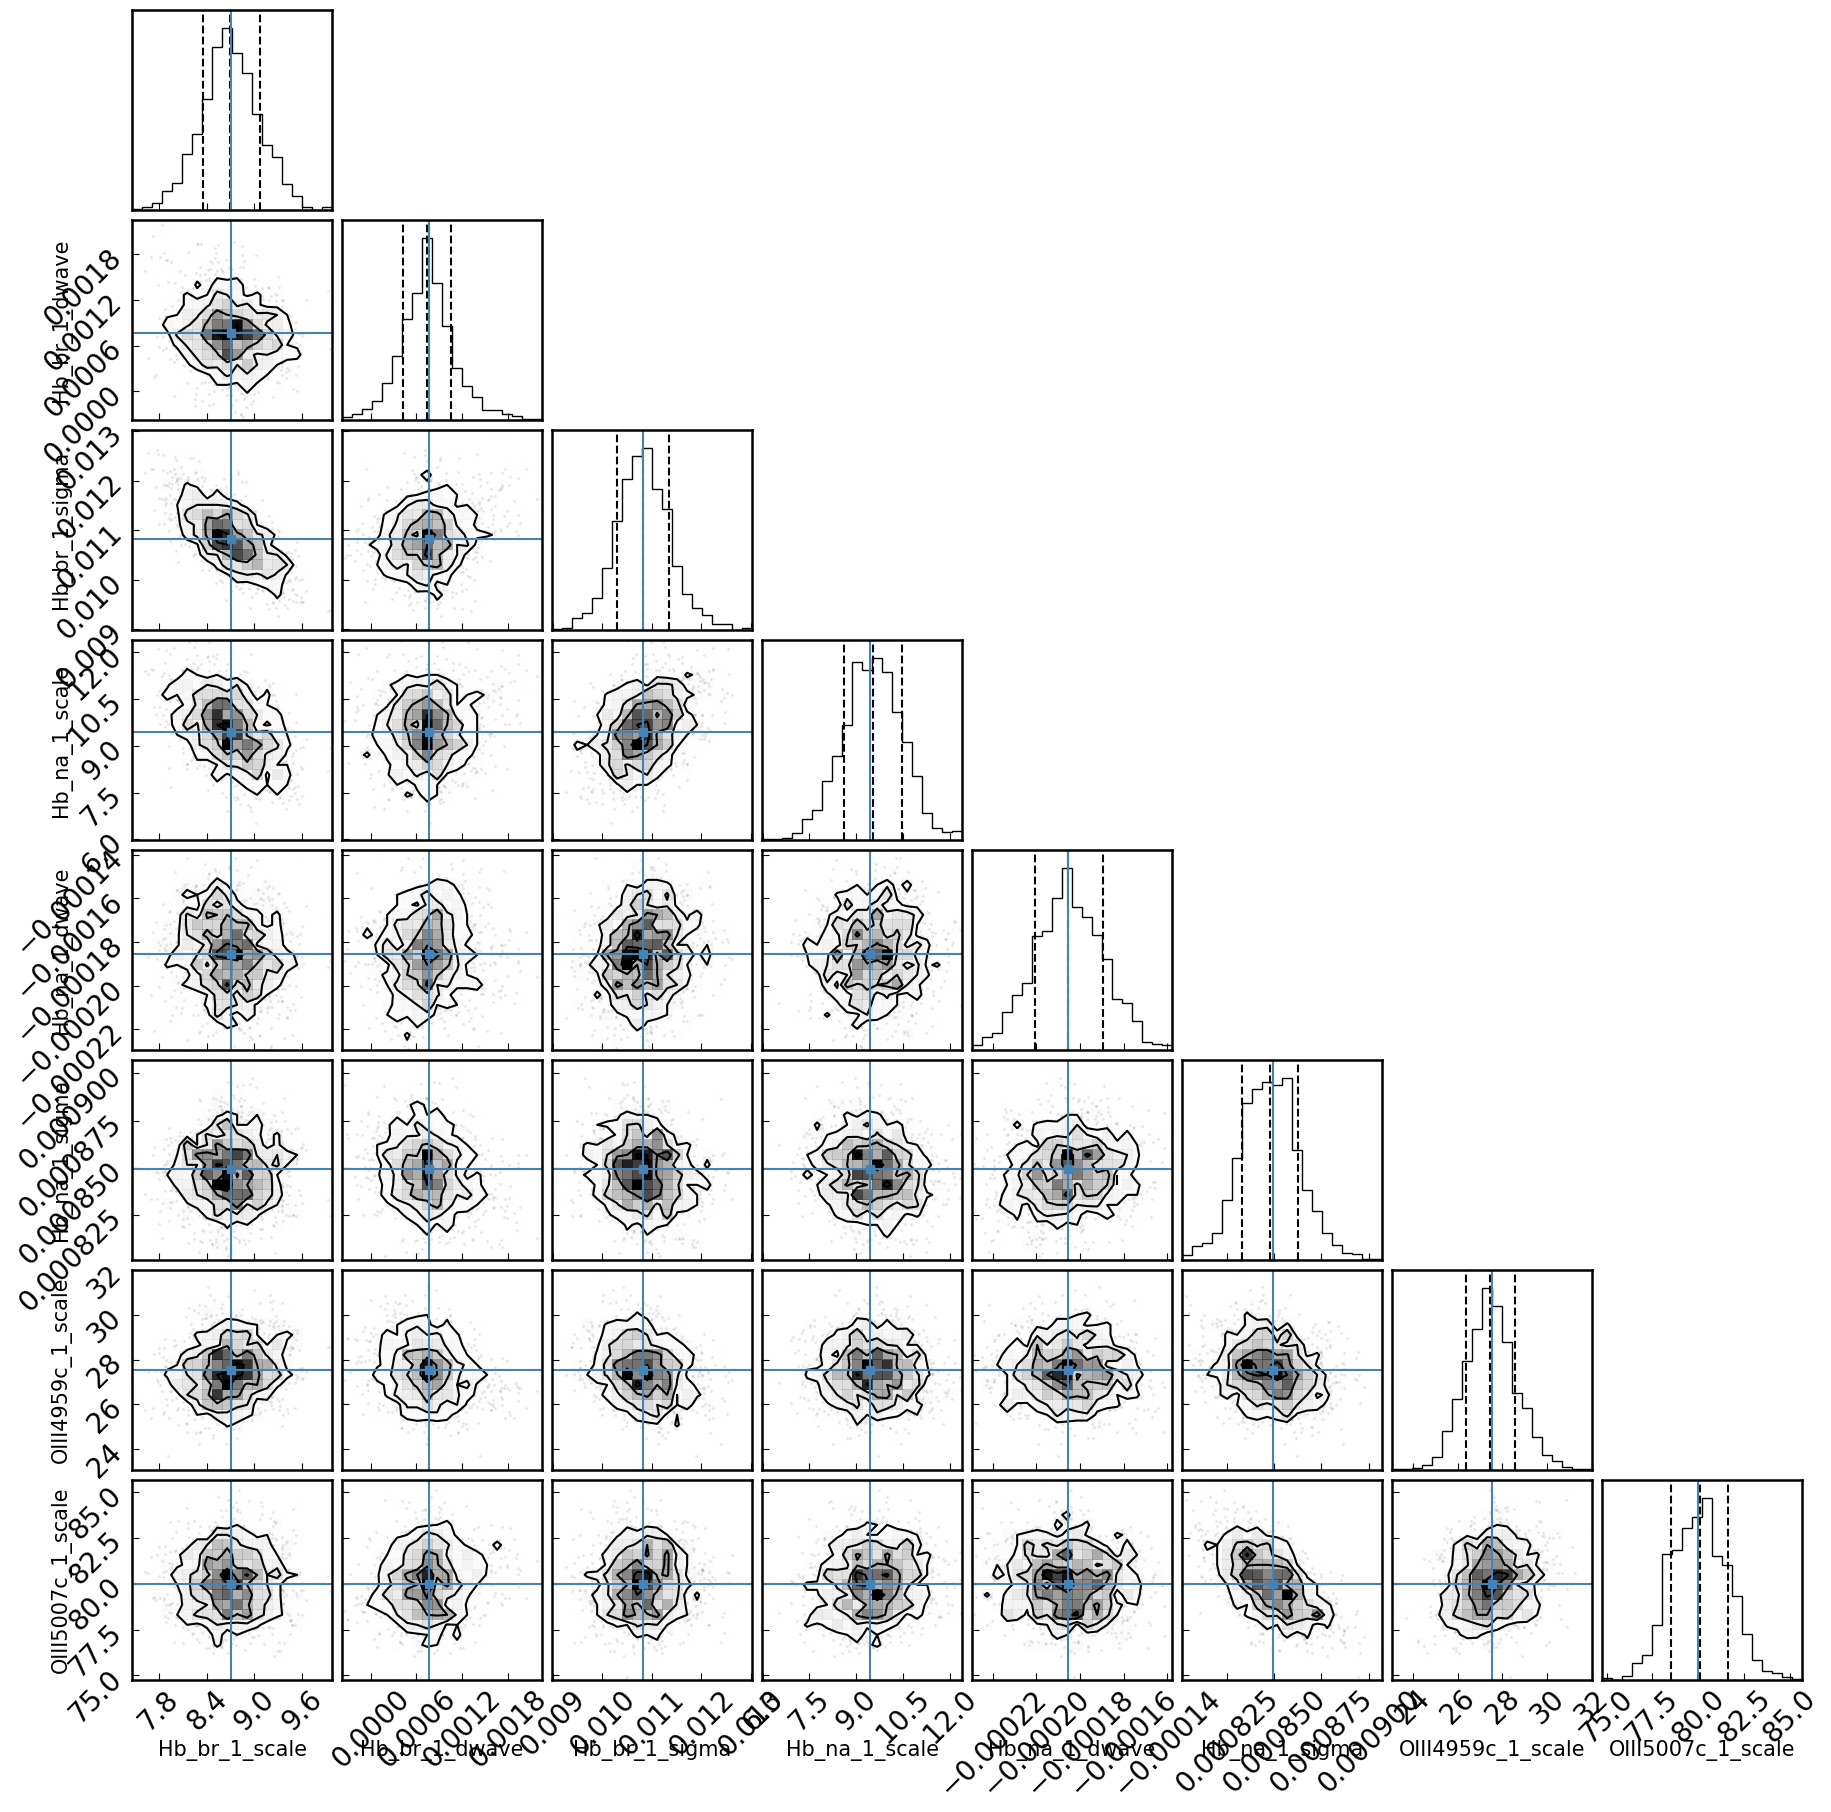

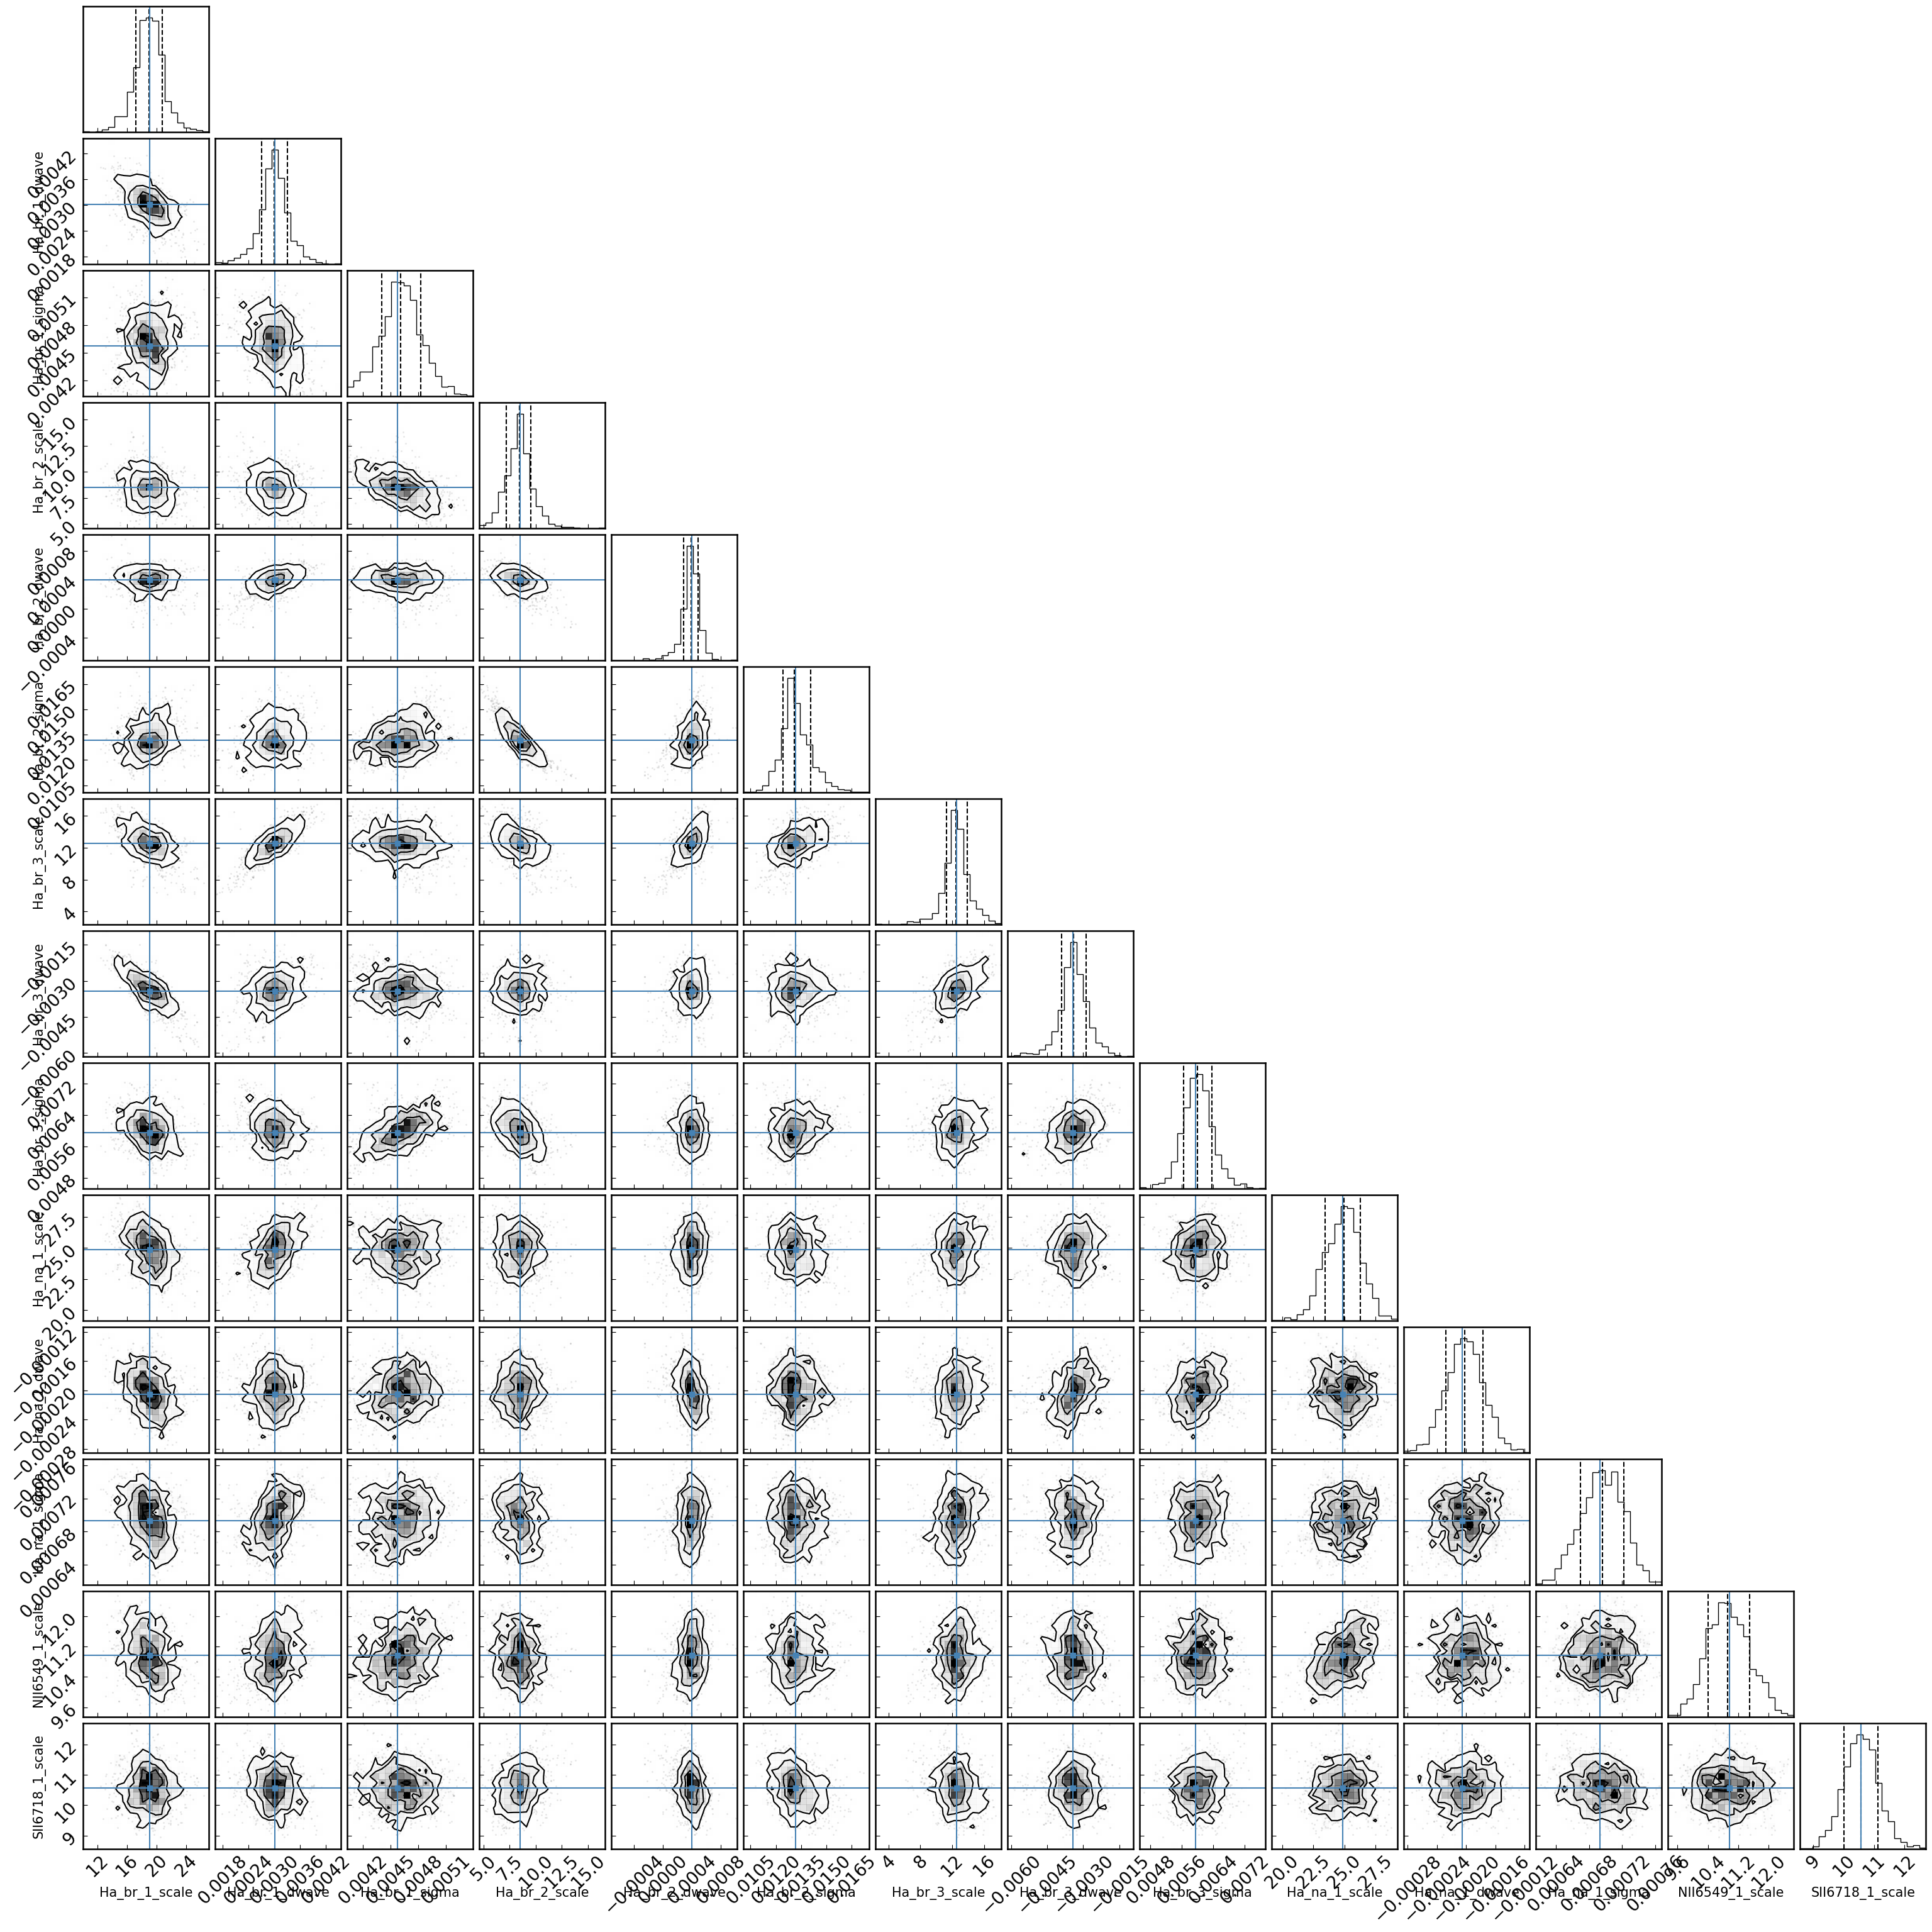

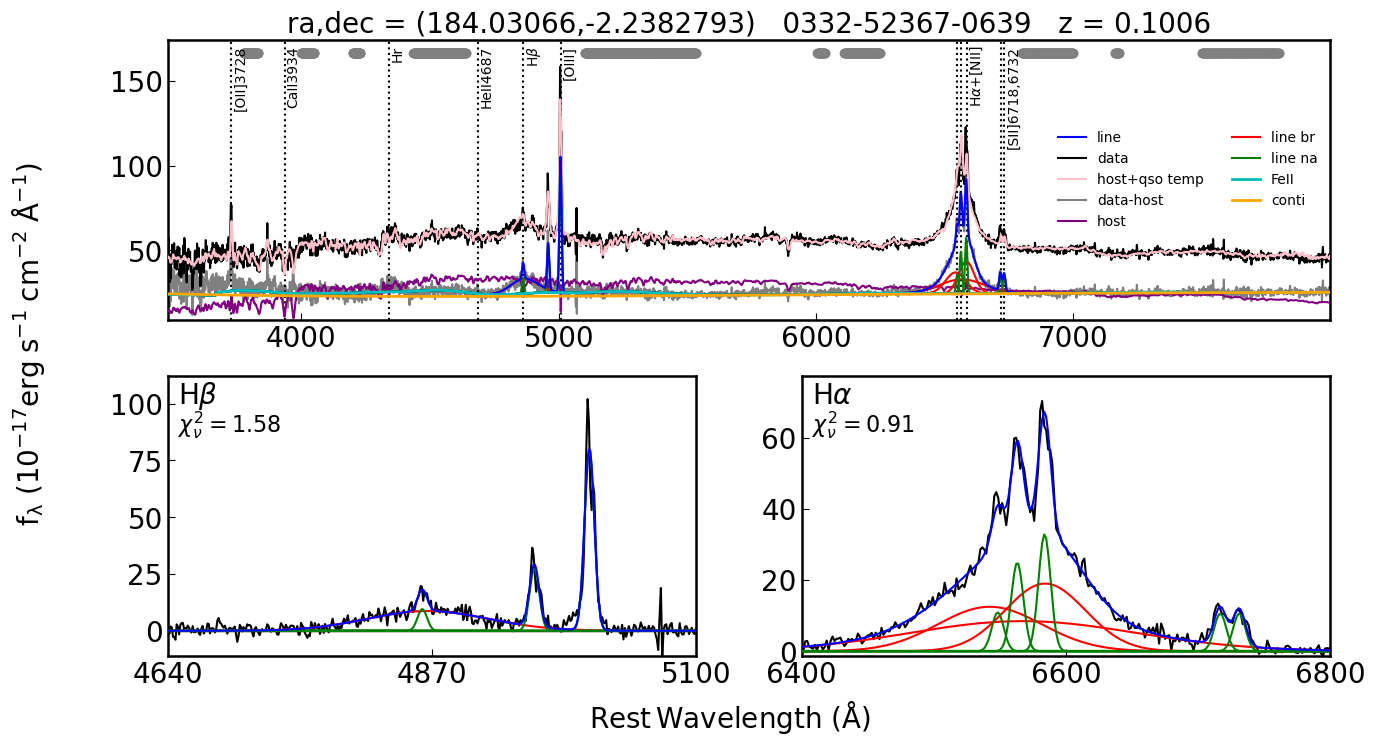

In [8]:
start = timeit.default_timer()
# Do the fitting
q.Fit(name=None, nsmooth=1, and_or_mask=False, deredden=True, reject_badpix=False, wave_range=None, \
      wave_mask=None, decomposition_host=True, Mi=None, npca_gal=5, npca_qso=20, \
      Fe_uv_op=True, Fe_flux_range=np.array([4435,4685]), poly=True, BC=False, rej_abs=False, \
      initial_guess=None, method='leastsq', MCMC=True, nburn=50, nsamp=200, nthin=10, linefit=True, \
      epsilon_jitter=1e-5, save_result=False, plot_fig=True, save_fig=False, plot_corner=True, \
      plot_line_name=True, plot_legend=True, dustmap_path=None, save_fig_path=path_out, \
      save_fits_path=path_out, save_fits_name=None, verbose=False)

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

When ``MCMC=True``, the posterior median values of each parameter are used for the ''best-fit'' parameter point estimates and the 1$\sigma$ uncertainties (from the 16th and 84th percentiles) are added to the results. The initial MLE fit will again be computed and is used as the starting point for emcee (you don't have to run with ``MCMC=False`` false first unless you really want to use the pure MLE parameter estimates). 

You may need to turn off/on continuum fitting components or adjust the parameter bounds as neccessary to fit your data. From the above plots, it is clear that the parameter posteriors are reasonably well-constrained. For more details, such as to view the acceptance fraction, use ``verbose=True``.

__View results:__ The results arrays will include the uncertainties on each parameter only if MCMC is used.

In [9]:
# Continuum fitting results
print(q.conti_result_name)
print('')
print(q.conti_result)

['ra' 'dec' 'plateid' 'MJD' 'fiberid' 'redshift' 'SN_ratio_conti'
 'Fe_uv_norm' 'Fe_uv_norm_err' 'Fe_uv_FWHM' 'Fe_uv_FWHM_err' 'Fe_uv_shift'
 'Fe_uv_shift_err' 'Fe_op_norm' 'Fe_op_norm_err' 'Fe_op_FWHM'
 'Fe_op_FWHM_err' 'Fe_op_shift' 'Fe_op_shift_err' 'PL_norm' 'PL_norm_err'
 'PL_slope' 'PL_slope_err' 'Blamer_norm' 'Blamer_norm_err' 'Balmer_Te'
 'Balmer_Te_err' 'Balmer_Tau' 'Balmer_Tau_err' 'conti_pl_0'
 'conti_pl_0_err' 'conti_pl_1' 'conti_pl_1_err' 'conti_pl_2'
 'conti_pl_2_err' 'L1350' 'L1350_err' 'L3000' 'L3000_err' 'L5100'
 'L5100_err' 'Fe_flux_4435_4685' 'Fe_flux_4435_4685_err']

['184.03066' '-2.2382793' '332' '52367' '639' '0.100609764'
 '27.49352773461182' '0.0' '0.0' '3000.0000103950238' '0.0'
 '6.613313558392745e-06' '0.0' '2.004124860080462' '0.067413885660771'
 '10421.166166509207' '320.0841925865084' '0.005267528153052384'
 '0.0005126414781812766' '26.398996101005007' '0.20587925526205453'
 '-1.4650118117263347' '0.03514164540017184' '0.0' '0.0'
 '15000.000001924567' '0.

In [10]:
# Gaussian fitting results
print(q.gauss_result_name)
print('')
print(q.gauss_result)

['Hb_br_1_scale' 'Hb_br_1_scale_err' 'Hb_br_1_centerwave'
 'Hb_br_1_centerwave_err' 'Hb_br_1_sigma' 'Hb_br_1_sigma_err'
 'Hb_na_1_scale' 'Hb_na_1_scale_err' 'Hb_na_1_centerwave'
 'Hb_na_1_centerwave_err' 'Hb_na_1_sigma' 'Hb_na_1_sigma_err'
 'OIII4959c_1_scale' 'OIII4959c_1_scale_err' 'OIII4959c_1_centerwave'
 'OIII4959c_1_centerwave_err' 'OIII4959c_1_sigma' 'OIII4959c_1_sigma_err'
 'OIII5007c_1_scale' 'OIII5007c_1_scale_err' 'OIII5007c_1_centerwave'
 'OIII5007c_1_centerwave_err' 'OIII5007c_1_sigma' 'OIII5007c_1_sigma_err'
 'Ha_br_1_scale' 'Ha_br_1_scale_err' 'Ha_br_1_centerwave'
 'Ha_br_1_centerwave_err' 'Ha_br_1_sigma' 'Ha_br_1_sigma_err'
 'Ha_br_2_scale' 'Ha_br_2_scale_err' 'Ha_br_2_centerwave'
 'Ha_br_2_centerwave_err' 'Ha_br_2_sigma' 'Ha_br_2_sigma_err'
 'Ha_br_3_scale' 'Ha_br_3_scale_err' 'Ha_br_3_centerwave'
 'Ha_br_3_centerwave_err' 'Ha_br_3_sigma' 'Ha_br_3_sigma_err'
 'Ha_na_1_scale' 'Ha_na_1_scale_err' 'Ha_na_1_centerwave'
 'Ha_na_1_centerwave_err' 'Ha_na_1_sigma' 'Ha_na_1_sig

In [11]:
# line fitting results
print(q.line_result_name)
print('')
print(q.line_result)

['1_complex_name' '1_line_status' '1_line_min_chi2' '1_line_red_chi2'
 '1_niter' '1_ndof' '2_complex_name' '2_line_status' '2_line_min_chi2'
 '2_line_red_chi2' '2_niter' '2_ndof' 'Hb_br_1_scale' 'Hb_br_1_scale_err'
 'Hb_br_1_centerwave' 'Hb_br_1_centerwave_err' 'Hb_br_1_sigma'
 'Hb_br_1_sigma_err' 'Hb_na_1_scale' 'Hb_na_1_scale_err'
 'Hb_na_1_centerwave' 'Hb_na_1_centerwave_err' 'Hb_na_1_sigma'
 'Hb_na_1_sigma_err' 'OIII4959c_1_scale' 'OIII4959c_1_scale_err'
 'OIII4959c_1_centerwave' 'OIII4959c_1_centerwave_err' 'OIII4959c_1_sigma'
 'OIII4959c_1_sigma_err' 'OIII5007c_1_scale' 'OIII5007c_1_scale_err'
 'OIII5007c_1_centerwave' 'OIII5007c_1_centerwave_err' 'OIII5007c_1_sigma'
 'OIII5007c_1_sigma_err' 'Ha_br_1_scale' 'Ha_br_1_scale_err'
 'Ha_br_1_centerwave' 'Ha_br_1_centerwave_err' 'Ha_br_1_sigma'
 'Ha_br_1_sigma_err' 'Ha_br_2_scale' 'Ha_br_2_scale_err'
 'Ha_br_2_centerwave' 'Ha_br_2_centerwave_err' 'Ha_br_2_sigma'
 'Ha_br_2_sigma_err' 'Ha_br_3_scale' 'Ha_br_3_scale_err'
 'Ha_br_3_centerw

__Step 4: Get all models for the whole spectrum__ <br>
Continue to look at this section and below if you want to do some further calculations based on the fitting results. Here, we show how to extract different models from our fitting results, such as continuum model, emission line models and host galaxy component. Note that the emission regions of host galaxy template should be blocked, e.g., H$\alpha$ [6540, 6590].

There are two ways to calculate the Fe II flux within given ranges:
1. If you want the program calculate the Fe II flux automatically and documented them in result file, you can use the parameter `Fe_flux_range` in `Fit()` to assign ranges.
2. We also provide build-in function `Get_Fe_flux` to calculate the Fe II flux directly after you finished the fitting part.

optical Fe flux (10^(-17) erg/s/cm^2): 771.225473018905
Fe flux within a specific range: 
Fe_flux_4400_4900: 1164.248668229152


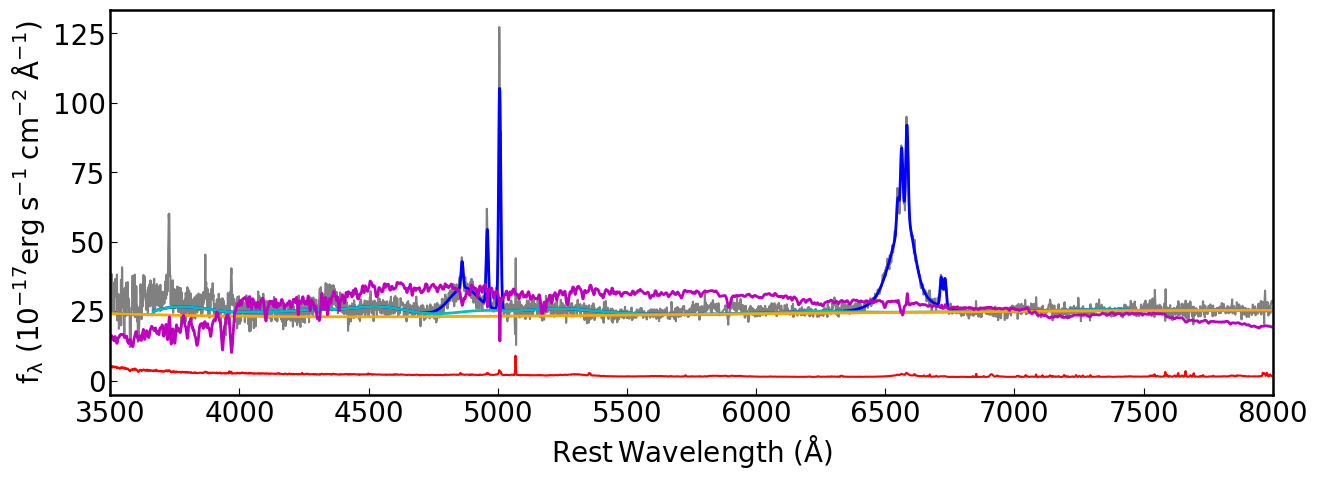

In [12]:
fig, ax = plt.subplots(figsize=(15,5))

# Plot the quasar rest frame spectrum after removed the host galaxy component
ax.plot(q.wave, q.flux, 'grey')
ax.plot(q.wave, q.err, 'r')

# Skip the error results before plotting
if q.MCMC:
    gauss_result = q.gauss_result[::2]
else:
    gauss_result = q.gauss_result


# To plot the whole model, we use Manygauss to show the line fitting results saved in gauss_result  
ax.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result) + q.f_conti_model, 'b', label='line', lw=2)
ax.plot(q.wave, q.f_conti_model, 'c', lw=2)
ax.plot(q.wave, q.PL_poly_BC, 'orange', lw=2)
ax.plot(q.wave, q.host, 'm', lw=2)

ax.set_xlim(3500, 8000)
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize=20)
ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)

print('optical Fe flux (10^(-17) erg/s/cm^2): ' + q.conti_result[q.conti_result_name=='Fe_flux_4435_4685'][0])

Fe_flux_result, Fe_flux_type, Fe_flux_name = q.Get_Fe_flux(np.array([4400,4900]))
print('Fe flux within a specific range: \n'+Fe_flux_name[0]+': '+str(Fe_flux_result[0]))

__Step 5: Get models for each line complex__ <br>
All the line parameters are in the gauss_result, it was saved following the order of ``qsopar.fits``. For each Gaussian, three parameter (scale, ln lambda, ln sigma) are saved.
If you want to filter the line below or above 1200 km/s (ln sigma = 0.0017), the function ``CalFWHM`` can be used as following.

The line_prop is designed to calculate the broad line properties, not for the narrow line. It is saved in the line_result property, but can be computed again.

In [13]:
def line_prop_from_name(line_name, line_type='broad'):
    """
    line_name: line name e.g., 'Ha_br'
    """
    
    # Get the complex center wavelength of the line_name component
    mask_name = q.linelist['linename'] == line_name
    compcenter = q.linelist[mask_name]['lambda'][0]

    # Get each Gaussian component
    ngauss = int(q.linelist[mask_name]['ngauss'][0])
    pp = np.zeros(ngauss*3)
    
    for n in range(ngauss):
    
        # Get the Gaussian properties
        pp[n] = float(q.line_result[q.line_result_name == f'{line_name}_{n+1}_scale'][0])
        pp[n+1] = float(q.line_result[q.line_result_name == f'{line_name}_{n+1}_centerwave'][0])
        pp[n+2] = float(q.line_result[q.line_result_name == f'{line_name}_{n+1}_sigma'][0])
    
    return q.line_prop(compcenter, pp, line_type)

Broad Hb:
FWHM (km/s) 7646.9
Sigma (km/s) 3204.1
EW (A) 49.7
Peak (A) 4865.7
area (10^(-17) erg/s/cm^2) 1144.5

Narrow [OIII]5007:
FWHM (km/s) 604.0
Sigma (km/s) 251.1
EW (A) 36.8
Peak (A) 5006.7
area (10^(-17) erg/s/cm^2) 851.6


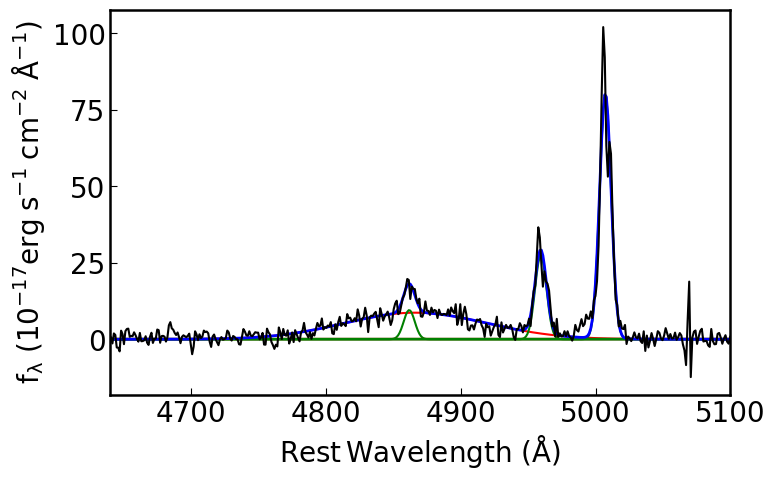

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

if q.MCMC:
    gauss_result = q.gauss_result[::2]
else:
    gauss_result = q.gauss_result

# Plot individual line components
for p in range(len(gauss_result)//3):
    if q.CalFWHM(gauss_result[3*p+2]) < 1200:  # < 1200 km/s narrow
        color = 'g' # narrow
    else:
        color = 'r' # broad
    ax.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p*3:(p+1)*3]), color=color)
    
# Plot total line model
ax.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=2)
ax.plot(q.wave, q.line_flux,'k')
plt.xlim(4640, 5100)
plt.xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize = 20)
plt.ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize = 20)


"""
Line properties
"""

# The line_prop function is used to calculate the broad line properties
# (defined, by default, as ln sigma > 0.0017 (1200 km/s) )

# OLD WAY: If you want to calculate the paramters of broad Hb
# then find all the broad Hb component, i.e., Hb_br_[1,2,3]_[scale,centerwave,sigma]
# for here q.line_result_name[12:15], q.line_result[12:15] is the broad Hb
# If MCMC=False, this would be:
# fwhm, sigma, ew, peak, area = q.line_prop(q.linelist[6][0], q.line_result[12:15], 'broad')

# NEW WAY: using line_prop_from_name convenience function
fwhm, sigma, ew, peak, area = q.line_prop_from_name('Hb_br', 'broad')

print("Broad Hb:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("area (10^(-17) erg/s/cm^2)", np.round(area, 1))
print("")


# OLD WAY: If you want to calculate the  the narrow [OIII]5007
# If MCMC=False, this would be:
# the coresponding parameters are  q.line_result_name[21:24], q.line_result[21:24]
# fwhm, sigma, ew, peak, area = q.line_prop(q.linelist[6][0], q.line_result[21:24], 'narrow')

fwhm, sigma, ew, peak, area = q.line_prop_from_name('OIII5007c', 'narrow')

print("Narrow [OIII]5007:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("area (10^(-17) erg/s/cm^2)", np.round(area, 1))

__Multiproccessing example:__ <br>
Uncertainty computation will cost some time, so we always use the multiprocessing to speed up fitting a large sample of many quasar spectra. 

We note that running multiprocessing on jupyter notebook may lead to various errors depending on the environment. The example here is only tested in MacOS Big Sur 11.2 with python 3.8.5. Running multiprocessing in non-interactive interpreters is recommended. For more information see https://docs.python.org/3/library/multiprocessing.html

*Memory leak warning*: For the convenience of display, the code wouldn't close the figure automatically which could lead to memory leak by child process if one uses multiprocessing. Considering the common memory size of modern computer is relatively large, dealing with a small amount of spectrum (say, less than 100) at a time is acceptable and those occupied memory would be released once the main process ends. However, if one needs to handle more spectrum, one can add `plt.close()` at the end of the function `QSOFit._PlotFig` in `PyQSOFit.py` or at the child process after spectrum are fitted (`import matplotlib.pyplot as plt` is also needed).

In [15]:
%%writefile temp_job.py

import numpy as np
from pyqsofit.PyQSOFit import QSOFit
from astropy.io import fits

path_ex = '/home/colinjb2/PyQSOFit/example/' # path of spectra
path_out = '/home/colinjb2/PyQSOFit/example/data/' # path of fitting results


def job(file):
    
    print(file + '\n')
    
    data = fits.open(file)
    
    lam = 10**data[1].data['loglam']
    flux = data[1].data['flux']
    err = 1/np.sqrt(data[1].data['ivar'])
    ra = data[0].header['plug_ra']
    dec = data[0].header['plug_dec']
    z = data[2].data['z'][0]
    plateid = data[0].header['plateid']
    mjd = data[0].header['mjd']
    fiberid = data[0].header['fiberid']
    
    q = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_ex)

    q.Fit(name=None, nsmooth=1, and_or_mask=False, deredden=True, reject_badpix=False, wave_range=None, wave_mask=None,
          decomposition_host=True, Mi=None, npca_gal=5, npca_qso=20, Fe_uv_op=True, poly=True, BC=False, rej_abs=False,
          initial_guess=None, MCMC=False, plot_fig=True, save_fig=True, plot_line_name=True, plot_legend=True,
          save_fig_path=path_out, save_fits_path=path_out, save_fits_name=None, verbose=False)

Writing temp_job.py


In [16]:
# Edit the directory before use
from multiprocessing import Pool
from temp_job import job
import os, timeit, glob

if __name__ == '__main__':
    start = timeit.default_timer()
    
    files = glob.glob(os.path.join(path_ex, 'data/spec-*.fits'))
    
    pool = Pool() # Create a multiprocessing Pool
    pool.map(job, files)
    
    end = timeit.default_timer()
    print(f'Fitting finished in : {np.round(end - start)}s')

os.remove('temp_job.py')

/home/colinjb2/PyQSOFit/example/data/spec-0266-51602-0013.fits
/home/colinjb2/PyQSOFit/example/data/spec-0332-52367-0639.fits
/home/colinjb2/PyQSOFit/example/data/spec-0266-51602-0107.fits



Reading parameter file: /home/colinjb2/PyQSOFit/example/qsopar.fits
Reading parameter file: /home/colinjb2/PyQSOFit/example/qsopar.fits
Reading parameter file: /home/colinjb2/PyQSOFit/example/qsopar.fits
Fitting finished in : 2.0s


### 2. Fit emission line galaxy
This code can also fit emission line galaxies, Narrow-line Seyfert 1 (NLS1) galaxies, etc.

Reading parameter file: /home/colinjb2/PyQSOFit/example/qsopar.fits


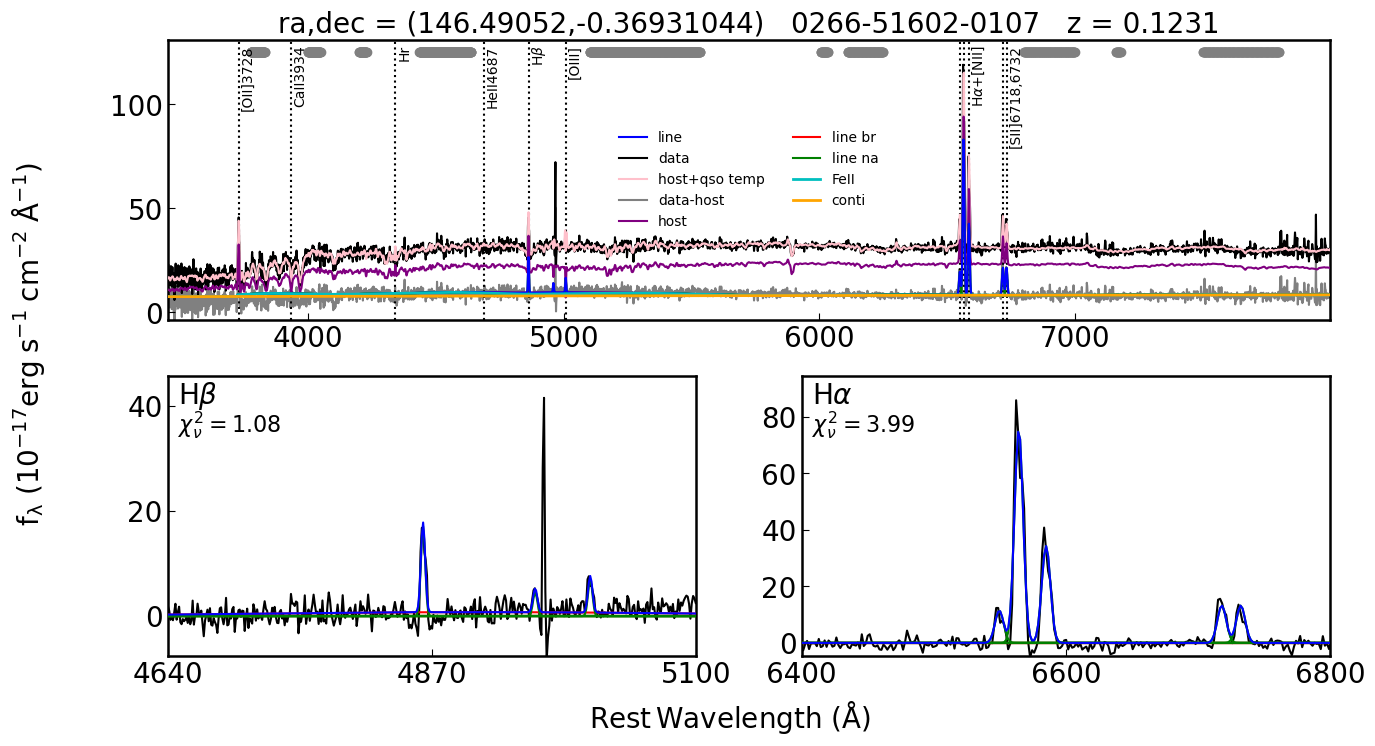

In [17]:
data = fits.open(os.path.join(path_ex, 'data/spec-0266-51602-0107.fits'))
lam = 10**data[1].data['loglam']        # OBS wavelength [A]
flux = data[1].data['flux']             # OBS flux [erg/s/cm^2/A]
err = 1/np.sqrt(data[1].data['ivar'])   # 1 sigma error
z = data[2].data['z'][0]                # Redshift


# Optional
ra = data[0].header['plug_ra']          # RA 
dec = data[0].header['plug_dec']        # DEC
plateid = data[0].header['plateid']     # SDSS plate ID
mjd = data[0].header['mjd']             # SDSS MJD
fiberid = data[0].header['fiberid']     # SDSS fiber ID


q = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_ex)

q.Fit(name=None, nsmooth=1, and_or_mask=False, deredden=True, reject_badpix=False, wave_range=None,\
      wave_mask=None, decomposition_host=True, Mi=None, npca_gal=5, npca_qso=20,\
      Fe_uv_op=True, poly=False, BC=False, rej_abs=False, initial_guess=None, MCMC=False, \
      save_result=True, plot_fig=True, save_fig=False, plot_line_name=True, plot_legend=True, \
      save_fig_path=path_out, save_fits_path=path_out, save_fits_name=None)

### 3. Fit normal galaxy
From the fitting, we can get the host galaxy component. Then we can use [pPXF](http://www-astro.physics.ox.ac.uk/~mxc/software/) to get the velocity dispersion and starformation history.

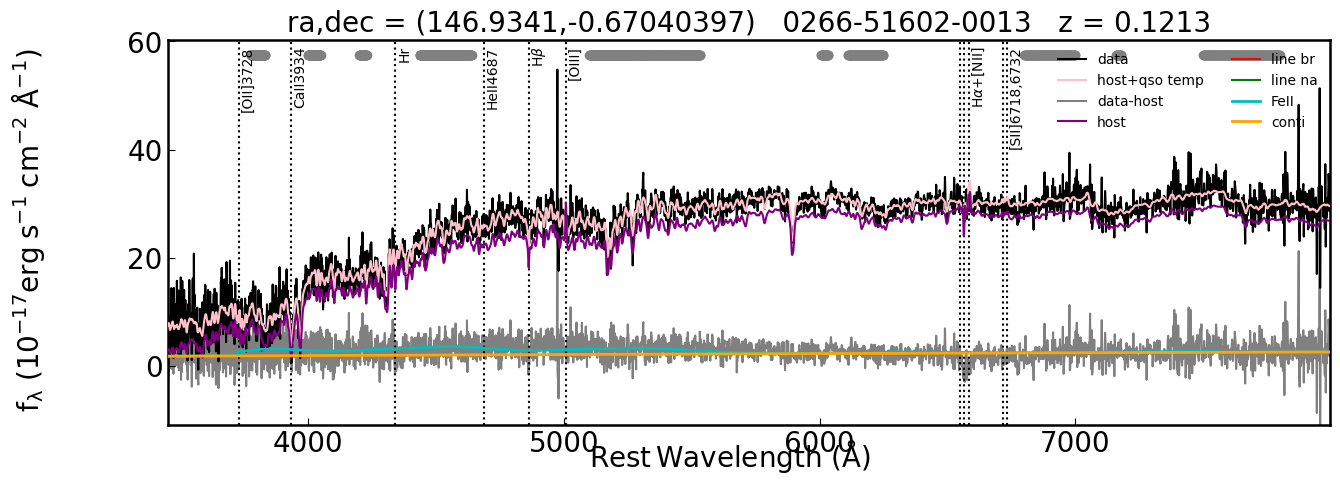

In [18]:
data = fits.open(os.path.join(path_ex, 'data/spec-0266-51602-0013.fits'))
lam = 10**data[1].data['loglam']        # OBS wavelength [A]
flux = data[1].data['flux']             # OBS flux [erg/s/cm^2/A]
err = 1/np.sqrt(data[1].data['ivar'])   # 1 sigma error
z = data[2].data['z'][0]                # Redshift

# Optional
ra = data[0].header['plug_ra']          # RA 
dec = data[0].header['plug_dec']        # DEC
plateid = data[0].header['plateid']     # SDSS plate ID
mjd = data[0].header['mjd']             # SDSS MJD
fiberid = data[0].header['fiberid']     # SDSS fiber ID


q = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_ex)

q.Fit(name=None, nsmooth=1, and_or_mask=False, deredden=True, reject_badpix=False, wave_range=None,\
      wave_mask=None, decomposition_host=True, Mi=None, npca_gal=5, npca_qso=20, linefit=False, \
      Fe_uv_op=True, poly=False, BC=False, rej_abs=False, initial_guess=None, MCMC=False, \
      save_result=True, plot_fig=True, save_fig=False, plot_line_name=True, plot_legend=True, \
      save_fig_path=path_out, save_fits_path=path_out, save_fits_name=None)

If the quasar continuum and broad-line signatures are very weak (e.g., LLAGN), it might be best to use ``pPXF`` first to get the galaxy component *then* use ``QSOFit`` with ``decomposition_host=False`` after subtracting the galaxy component from the initial spectrum. For LLAGN, MCMC might also be useful when the broad/narrow emission line components might be more ambiguous.